# **Oanda Broker Connection**

In [11]:
import tpqoa
import pandas as pd
import numpy as np

In [2]:
# need to remember to encrypt this cfg file later!!
api = tpqoa.tpqoa('../../data/keys.cfg')

In [3]:
# Look up instruments which you can trade

api.get_instruments()[:20]

[('AUD/CAD', 'AUD_CAD'),
 ('AUD/CHF', 'AUD_CHF'),
 ('AUD/HKD', 'AUD_HKD'),
 ('AUD/JPY', 'AUD_JPY'),
 ('AUD/NZD', 'AUD_NZD'),
 ('AUD/SGD', 'AUD_SGD'),
 ('AUD/USD', 'AUD_USD'),
 ('CAD/CHF', 'CAD_CHF'),
 ('CAD/HKD', 'CAD_HKD'),
 ('CAD/JPY', 'CAD_JPY'),
 ('CAD/SGD', 'CAD_SGD'),
 ('CHF/HKD', 'CHF_HKD'),
 ('CHF/JPY', 'CHF_JPY'),
 ('CHF/ZAR', 'CHF_ZAR'),
 ('EUR/AUD', 'EUR_AUD'),
 ('EUR/CAD', 'EUR_CAD'),
 ('EUR/CHF', 'EUR_CHF'),
 ('EUR/CZK', 'EUR_CZK'),
 ('EUR/DKK', 'EUR_DKK'),
 ('EUR/GBP', 'EUR_GBP')]

In [4]:
# backtesting a momentum strategy on minute bars

# lets get the raw historical data
help(api.get_history)

Help on method get_history in module tpqoa.tpqoa:

get_history(instrument, start, end, granularity, price, localize=True) method of tpqoa.tpqoa.tpqoa instance
    Retrieves historical data for instrument.
    
    Parameters
    instrument: string
        valid instrument name
    start, end: datetime, str
        Python datetime or string objects for start and end
    granularity: string
        a string like 'S5', 'M1' or 'D'
    price: string
        one of 'A' (ask), 'B' (bid) or 'M' (middle)
    
    Returns
    data: pd.DataFrame
        pandas DataFrame object with data



In [7]:
# examine the russian invasion of ukraine period
instrument = 'EUR_USD'
start = '2022-02-22'
end = '2022-02-24'
granularity = 'M1'
# mid price is the average of the bid and ask price
price = 'M'

data = api.get_history(instrument, start, end,granularity, price)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2858 entries, 2022-02-22 00:00:00 to 2022-02-23 23:59:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         2858 non-null   float64
 1   h         2858 non-null   float64
 2   l         2858 non-null   float64
 3   c         2858 non-null   float64
 4   volume    2858 non-null   int64  
 5   complete  2858 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 136.8 KB
None


,o,h,l,c,volume,complete
time,,,,,,
2022-02-22 00:00:00,1.13092,1.13106,1.13086,1.13092,158,True
2022-02-22 00:01:00,1.13092,1.13092,1.13082,1.13084,92,True
2022-02-22 00:02:00,1.13082,1.13088,1.13072,1.13072,102,True
2022-02-22 00:03:00,1.13072,1.13087,1.13072,1.13086,66,True
2022-02-22 00:04:00,1.13087,1.13104,1.13086,1.13102,82,True


In [18]:
class OandaMomentumVectorBacktester:
    '''
    Attributes
    ----------
    symbol: str
        The ticker to be analyzed
    start: str
        The start date of the security price time series
    end: end
        The end date of the security price time series
    amount: int, float
        The amount to be invested at the beginning
    tc: float
        proportional transaction costs (technically log transaction cost)

    Methods (no optimizer this time)
    -------
    get_data: retrieves and prepares the base data set
    run_strategy: runs the backtest for the momentum strategy
    plot_results: plots the cumulative performace of the trading strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, granularity, price, amount, tc, leverage):
        self.api = tpqoa.tpqoa('../../data/keys.cfg')
        self.symbol = symbol
        self.start = start
        self.end = end
        self.granularity = granularity
        self.amount = amount
        self.price = price
        self.tc = tc
        self.leverage = leverage
        self.results = None
        # when object is instantiated, lets call get data method to prepare base data set
        self.get_data()

    def get_data(self):
        raw = self.api.get_history(self.symbol, self.start, self.end, self.granularity, self.price)
        raw = raw[['c']].copy()
        raw.rename(columns={'c':'price'}, inplace=True)
        # once again, see Tsay. These are the log returns
        raw['log_returns'] = np.log(raw['price'].pct_change() + 1)
        self.data = raw
    
    def run_strategy(self, momentum=1):
        self.momentum = momentum
        data = self.data.copy().dropna()
        data['position'] = np.sign(data['log_returns'].rolling(self.momentum).mean())
        data['strategy'] = data['position'].shift(1) * data['log_returns']
        data.dropna(inplace=True)
        # booleans for where trades take place
        # the position is essentially step functions. The diff(), aka derivative, will be 1/-1 at the steps 
        # and zero everywhere else
        trades = data['position'].diff().fillna(0) != 0
        # subtract log of transaction costs from log returns (not too sure this is the correct way to do it.....)
        data['strategy'][trades] -= self.tc
        # disagreement here with Hilpisch on factoring in leverage. Showing what I think is correct, namely,
        # applying the multiplicative factor after the returns have been compounded
        data['buyhold_creturns'] = self.amount * data['log_returns'].cumsum().apply(np.exp).apply(lambda x: x * self.leverage)
        data['strategy_creturns'] = self.amount * data['strategy'].cumsum().apply(np.exp).apply(lambda x: x * self.leverage)
        # now update the results attribute
        self.results = data
        # absolute performance of the strategy
        aperf = self.results['strategy_creturns'][-1]
        # out/underperformance of strategy (difference between absolute performance of both strategies)
        operf = aperf - self.results['buyhold_creturns'][-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        if self.results is None:
            print("There are no results to plot!")
        else:
            self.results[['buyhold_creturns','strategy_creturns']].plot(title=f'''Performance of
             Strategy vs. Buy and Hold''', figsize=(10, 6))

Absolute and Out/underperformance of Momentum 1 strategy is: (201280.28, 3421.5)
Absolute and Out/underperformance of Momentum 1 strategy is: (200126.17, 2401.98)
Absolute and Out/underperformance of Momentum 1 strategy is: (200990.91, 3237.03)


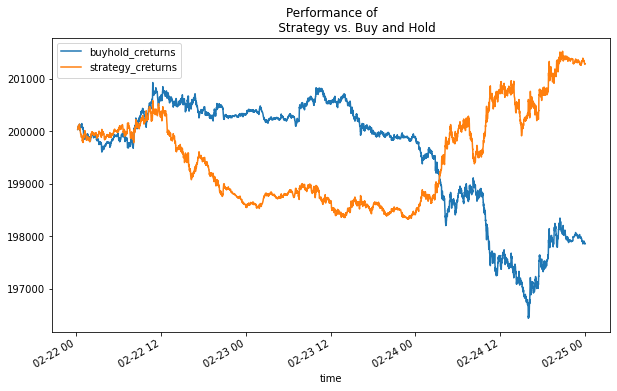

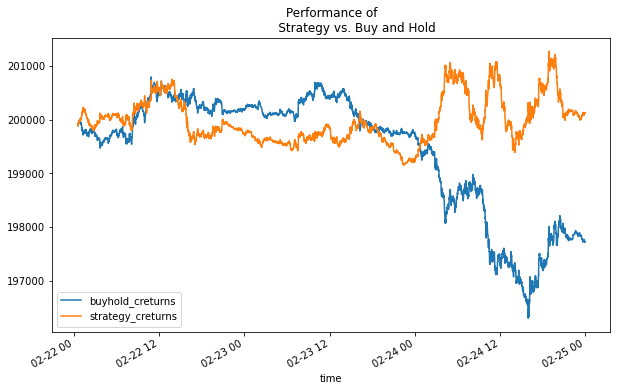

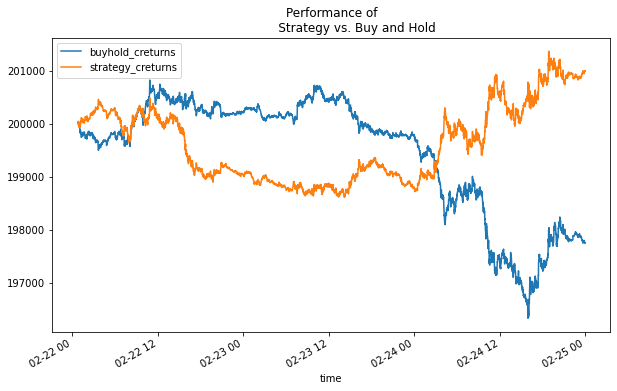

In [19]:
# examine the russian invasion of ukraine period
symbol = 'EUR_USD'
start = '2022-02-22'
end = '2022-02-25'
granularity = 'M1'
# mid price is the average of the bid and ask price
price = 'M'
leverage = 20

mombt = OandaMomentumVectorBacktester(symbol, start, end, granularity, price, 10000, 0, leverage)
# Momentum of 15
print(f"Absolute and Out/underperformance of Momentum 1 strategy is: {mombt.run_strategy(15)}")
# plot the results
mombt.plot_results()
# Momentum of 30
print(f"Absolute and Out/underperformance of Momentum 1 strategy is: {mombt.run_strategy(30)}")
# plot the results
mombt.plot_results()
# Momentum of 45
print(f"Absolute and Out/underperformance of Momentum 1 strategy is: {mombt.run_strategy(45)}")
# plot the results
mombt.plot_results()

### Streaming Data

In [21]:
api.stream_data('EUR_USD', stop=10)

2022-03-08T03:58:13.518577137Z 1.08679 1.08695
2022-03-08T03:58:19.964006811Z 1.0868 1.08694
2022-03-08T03:58:20.268129682Z 1.08679 1.08694
2022-03-08T03:58:22.505442585Z 1.08679 1.08692
2022-03-08T03:58:22.746377449Z 1.08676 1.08693
2022-03-08T03:58:22.885754430Z 1.08677 1.08692
2022-03-08T03:58:23.473699932Z 1.08676 1.08693
2022-03-08T03:58:25.554110422Z 1.08677 1.08692
2022-03-08T03:58:25.820486182Z 1.08677 1.08692
2022-03-08T03:58:26.451944256Z 1.08675 1.0869


In [22]:
help(api.create_order)

Help on method create_order in module tpqoa.tpqoa:

create_order(instrument, units, price=None, sl_distance=None, tsl_distance=None, tp_price=None, comment=None, touch=False, suppress=False, ret=False) method of tpqoa.tpqoa.tpqoa instance
    Places order with Oanda.
    
    Parameters
    instrument: string
        valid instrument name
    units: int
        number of units of instrument to be bought
        (positive int, eg 'units=50')
        or to be sold (negative int, eg 'units=-100')
    price: float
        limit order price, touch order price
    sl_distance: float
        stop loss distance price, mandatory eg in Germany
    tsl_distance: float
        trailing stop loss distance
    tp_price: float
        take profit price to be used for the trade
    comment: str
        string
    touch: boolean
        market_if_touched order (requires price to be set)
    suppress: boolean
        whether to suppress print out
    ret: boolean
        whether to return the order obje

In [23]:
# by default, market order
api.create_order('EUR_USD', 1000)



 {'id': '5', 'time': '2022-03-08T04:07:02.696849975Z', 'userID': 21798954, 'accountID': '101-001-21798954-001', 'batchID': '4', 'requestID': '42935609518878235', 'type': 'ORDER_FILL', 'orderID': '4', 'instrument': 'EUR_USD', 'units': '1000.0', 'gainQuoteHomeConversionFactor': '1.0', 'lossQuoteHomeConversionFactor': '1.0', 'price': 1.08677, 'fullVWAP': 1.08677, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.0866, 'liquidity': '10000000'}], 'asks': [{'price': 1.08677, 'liquidity': '10000000'}], 'closeoutBid': 1.0866, 'closeoutAsk': 1.08677}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '100000.0', 'tradeOpened': {'tradeID': '5', 'units': '1000.0', 'price': 1.08677, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.085', 'initialMarginRequired': '21.7336'}, 'halfSpreadCost': '0.085'} 



In [24]:
api.create_order('EUR_USD', -1500)



 {'id': '7', 'time': '2022-03-08T04:07:42.557344162Z', 'userID': 21798954, 'accountID': '101-001-21798954-001', 'batchID': '6', 'requestID': '42935609686702460', 'type': 'ORDER_FILL', 'orderID': '6', 'instrument': 'EUR_USD', 'units': '-1500.0', 'gainQuoteHomeConversionFactor': '1.0', 'lossQuoteHomeConversionFactor': '1.0', 'price': 1.08669, 'fullVWAP': 1.08669, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.08669, 'liquidity': '10000000'}], 'asks': [{'price': 1.08684, 'liquidity': '10000000'}], 'closeoutBid': 1.08669, 'closeoutAsk': 1.08684}, 'reason': 'MARKET_ORDER', 'pl': '-0.08', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99999.92', 'tradeOpened': {'tradeID': '7', 'units': '-500.0', 'price': 1.08669, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.0375', 'initialMarginRequired': '10.8676'}, 'tradesClosed': [{'tradeID': '5', 'units': '-1000.0', 'price': 1.08669, 'realizedPL': '-0.08', 'financing': '0.0', 'guaranteedExecut

In [25]:
# close out short position
api.create_order('EUR_USD', 500)


# you can see these previous orders on the desktop client!



 {'id': '9', 'time': '2022-03-08T04:10:35.818707623Z', 'userID': 21798954, 'accountID': '101-001-21798954-001', 'batchID': '8', 'requestID': '42935610412533055', 'type': 'ORDER_FILL', 'orderID': '8', 'instrument': 'EUR_USD', 'units': '500.0', 'gainQuoteHomeConversionFactor': '1.0', 'lossQuoteHomeConversionFactor': '1.0', 'price': 1.0867, 'fullVWAP': 1.0867, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.08654, 'liquidity': '10000000'}], 'asks': [{'price': 1.0867, 'liquidity': '10000000'}], 'closeoutBid': 1.08654, 'closeoutAsk': 1.0867}, 'reason': 'MARKET_ORDER', 'pl': '-0.005', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99999.915', 'tradesClosed': [{'tradeID': '7', 'units': '500.0', 'price': 1.0867, 'realizedPL': '-0.005', 'financing': '0.0', 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.04'}], 'halfSpreadCost': '0.04'} 



## Real Time Strategies

In [30]:
class MomentumTrader(tpqoa.tpqoa):
    def __init__(self, conf_file, instrument, bar_length, momentum, units,
                *args, **kwargs):
        # super allows one to use methods of base class
        super(MomentumTrader, self).__init__(conf_file)
        self.position = 0
        self.instrument = instrument
        self.momentum = momentum
        self.bar_length = bar_length
        self.units = units
        self.raw_data = pd.DataFrame()
        self.min_length = self.momentum + 1

    def on_success(self, time, bid, ask):
        ''' Takes actions when new tick data arrives. '''
        # tick is just a counter of the number of datapoints streamed
        print(self.ticks, end=' ')
        # append the bid and ask with timestamp as index in a dataframe to
        # the raw_data dataframe
        self.raw_data = pd.concat([self.raw_data, pd.DataFrame(
            {'bid': bid, 'ask': ask}, index=[pd.Timestamp(time)])])
        # need to go under the hood here and validate
        self.data = self.raw_data.resample(
            self.bar_length, label='right').last().ffill().iloc[:-1]
        self.data['mid'] = self.data.mean(axis=1)
        self.data['log_returns'] = np.log(self.data['mid'] /
                                      self.data['mid'].shift(1))
        # standard momentum strategy
        self.data['position'] = np.sign(
            self.data['log_returns'].rolling(self.momentum).mean())
        
        if len(self.data) > self.min_length:
            self.min_length += 1
            # if strategy gives a long signal
            if self.data['position'].iloc[-1] == 1:
                # if you're market neutral
                if self.position == 0:
                    # go long
                    self.create_order(self.instrument, self.units)
                # else if you're short
                if self.position == -1:
                    # close out position and go long
                    self.create_order(self.instrument, 2 * self.units)
                # set position to long
                self.position = 1
            # else if strategy gives a short signal
            elif self.data['position'].iloc[-1] == -1:
                # if you're market neutral
                if self.position == 0:
                    # short it
                    self.create_order(self.instrument, -self.units)
                # else if you're market long
                elif self.position == 1:
                    # close out position and go short
                    self.create_order(self.instrument, -2 * self.units)
                # set position to short
                self.position = -1

In [31]:
# strategy where you're trading DAX30 denominated in EURO I believe
# (DAX 30 index is a blue-chip market index of 30 of Germany's largest companies)
mom = MomentumTrader('../../data/keys.cfg', 'EUR_USD', '5s', 3, 1)
mom.stream_data(mom.instrument, stop=500)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

 {'id': '13', 'time': '2022-03-08T05:18:15.992185245Z', 'userID': 21798954, 'accountID': '101-001-21798954-001', 'batchID': '12', 'requestID': '42935627442027451', 'type': 'ORDER_FILL', 'orderID': '12', 'instrument': 'EUR_USD', 'units': '1.0', 'gainQuoteHomeConversionFactor': '1.0', 'lossQuoteHomeConversionFactor': '1.0', 'price': 1.08624, 'fullVWAP': 1.08624, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.08608, 'liquidity': '10000000'}], 'asks': [{'price': 1.08624, 'liquidity': '10000000'}], 'closeoutBid': 1.08608, 'closeoutAsk': 1.08624}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99999.915', 'tradeOpened': {'tradeID': '13', 'units': '1.0', 'price': 1.08624, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.0001', 'initialMarginRequired': '0.0217'}, 'halfSpreadCost': '0.0001'} 

25 26 27 28 29 30 31 32 33 34 35 36 37 38 39

In [32]:
# close out the final position
oo = mom.create_order(mom.instrument, units=-mom.position * mom.units, ret=True, suppress=True)

In [33]:
oo

{'id': '67',
 'time': '2022-03-08T05:30:15.046073642Z',
 'userID': 21798954,
 'accountID': '101-001-21798954-001',
 'batchID': '66',
 'requestID': '42935630462807462',
 'type': 'ORDER_FILL',
 'orderID': '66',
 'instrument': 'EUR_USD',
 'units': '-1.0',
 'gainQuoteHomeConversionFactor': '1.0',
 'lossQuoteHomeConversionFactor': '1.0',
 'price': 1.08586,
 'fullVWAP': 1.08586,
 'fullPrice': {'type': 'PRICE',
  'bids': [{'price': 1.08586, 'liquidity': '10000000'}],
  'asks': [{'price': 1.08605, 'liquidity': '10000000'}],
  'closeoutBid': 1.08586,
  'closeoutAsk': 1.08605},
 'reason': 'MARKET_ORDER',
 'pl': '-0.0003',
 'financing': '0.0',
 'commission': '0.0',
 'guaranteedExecutionFee': '0.0',
 'accountBalance': '99999.911',
 'tradesClosed': [{'tradeID': '65',
   'units': '-1.0',
   'price': 1.08586,
   'realizedPL': '-0.0003',
   'financing': '0.0',
   'guaranteedExecutionFee': '0.0',
   'halfSpreadCost': '0.0001'}],
 'halfSpreadCost': '0.0001'}

In [34]:
# retrieve account info!

api.get_account_summary()

{'id': '101-001-21798954-001',
 'alias': 'Primary',
 'currency': 'USD',
 'balance': '99999.911',
 'createdByUserID': 21798954,
 'createdTime': '2022-02-27T23:16:07.059697900Z',
 'guaranteedStopLossOrderMode': 'DISABLED',
 'pl': '-0.089',
 'resettablePL': '-0.089',
 'resettablePLTime': '0',
 'financing': '0.0',
 'commission': '0.0',
 'guaranteedExecutionFees': '0.0',
 'marginRate': '0.02',
 'openTradeCount': 0,
 'openPositionCount': 0,
 'pendingOrderCount': 0,
 'hedgingEnabled': False,
 'unrealizedPL': '0.0',
 'NAV': '99999.911',
 'marginUsed': '0.0',
 'marginAvailable': '99999.911',
 'positionValue': '0.0',
 'marginCloseoutUnrealizedPL': '0.0',
 'marginCloseoutNAV': '99999.911',
 'marginCloseoutMarginUsed': '0.0',
 'marginCloseoutPercent': '0.0',
 'marginCloseoutPositionValue': '0.0',
 'withdrawalLimit': '99999.911',
 'marginCallMarginUsed': '0.0',
 'marginCallPercent': '0.0',
 'lastTransactionID': '67'}

In [35]:
# info on the last few transactions

api.get_transactions(tid=int(oo['id']) - 2)

[{'id': '66',
  'time': '2022-03-08T05:30:15.046073642Z',
  'userID': 21798954,
  'accountID': '101-001-21798954-001',
  'batchID': '66',
  'requestID': '42935630462807462',
  'type': 'MARKET_ORDER',
  'instrument': 'EUR_USD',
  'units': '-1.0',
  'timeInForce': 'FOK',
  'positionFill': 'DEFAULT',
  'reason': 'CLIENT_ORDER'},
 {'id': '67',
  'time': '2022-03-08T05:30:15.046073642Z',
  'userID': 21798954,
  'accountID': '101-001-21798954-001',
  'batchID': '66',
  'requestID': '42935630462807462',
  'type': 'ORDER_FILL',
  'orderID': '66',
  'instrument': 'EUR_USD',
  'units': '-1.0',
  'gainQuoteHomeConversionFactor': '1.0',
  'lossQuoteHomeConversionFactor': '1.0',
  'price': 1.08586,
  'fullVWAP': 1.08586,
  'fullPrice': {'type': 'PRICE',
   'bids': [{'price': 1.08586, 'liquidity': '10000000'}],
   'asks': [{'price': 1.08605, 'liquidity': '10000000'}],
   'closeoutBid': 1.08586,
   'closeoutAsk': 1.08605},
  'reason': 'MARKET_ORDER',
  'pl': '-0.0003',
  'financing': '0.0',
  'commis

In [36]:
# for succinct overview of transaction history
api.print_transactions(tid=int(oo['id']) - 18)

  51 | 2022-03-08T05:23:20.50 | EUR_USD |     -2.0 |  -0.0002
  53 | 2022-03-08T05:23:30.53 | EUR_USD |      2.0 |  -0.0002
  55 | 2022-03-08T05:23:47.06 | EUR_USD |     -2.0 |  -0.0002
  57 | 2022-03-08T05:24:21.12 | EUR_USD |      2.0 |  -0.0001
  59 | 2022-03-08T05:24:26.61 | EUR_USD |     -2.0 |  -0.0002
  61 | 2022-03-08T05:24:45.68 | EUR_USD |      2.0 |  -0.0002
  63 | 2022-03-08T05:24:56.68 | EUR_USD |     -2.0 |  -0.0002
  65 | 2022-03-08T05:25:25.46 | EUR_USD |      2.0 |  -0.0001
  67 | 2022-03-08T05:30:15.04 | EUR_USD |     -1.0 |  -0.0003
